## **Classification**

classification means teaching a model to assign input data into predefined categories or labels. The model learns from a labeled dataset, data that already contains the correct output—and then predicts the label for unseen data

There are multiple types of Classification tasks :

1. **Binary Classification** : The simplest form -- data points are categorized into one of two classes
2. **Multi-class Classification** : The model chooses one label from three or more possible classes
3. **Multi-label Classification** : Each data point can belong to multiple classes simultaneously
4. **Imbalanced Classification** : One class heavily dominates the dataset
5. **Ordinal Classification** : Categories have a natural order, but distances between them aren’t numeric

### **Binary Classification with MNIST Dataset**

The MNIST dataset is a set of 70k small images of digits handwritten by humans. This set can be used to come up with classification algorithms and exercise/practice classification based on these digits

We can explore this dataset, build a binary classifier based off of this and then also implement different features such as *Performance Measures*, *Cross-Validation*, *Confusion Matrix* and so on

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys() # data in the dataset about a single digit or image

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"] # X is the data and y is the label
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

Saving figure some_digit_plot


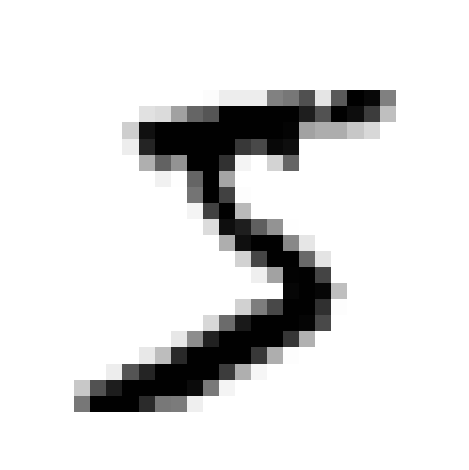

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0] # Check the label of the first image

'5'

Saving figure more_digits_plot


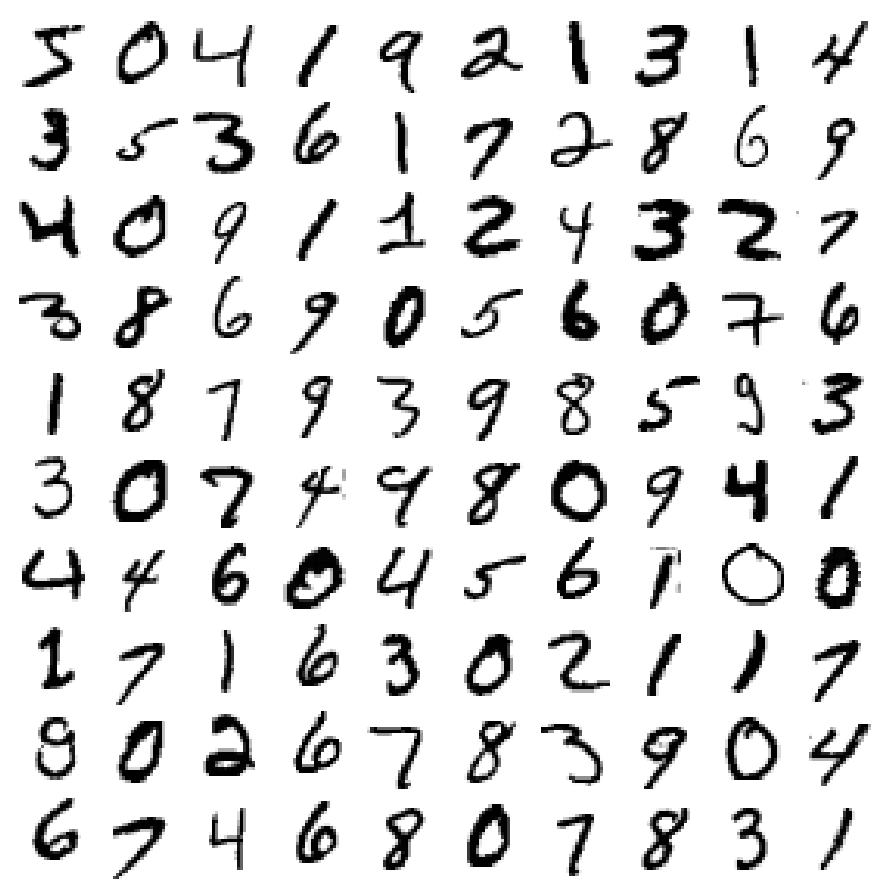

In [8]:
# OVERVIEW OF THE MNIST DATASET AND DIGITS
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

### **Training a Binary Classifier**

We will simplify the probelm and only try to identify one digit. This is an example of a binary classifier as it is capable of distinguising between only two classes : 5 and not-5

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# We will create the target vectors for this classification task :

# Recent versions of fetch_openml loads the y values as strings by default
y_train_5 = (y_train == '5') # True for all 5s and false for all other digits
y_test_5 = (y_test == '5')

np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([54579,  5421]))

In [11]:
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
# Using cross-validation to evaluate the performance of a model and assess how well it will generalize to unseen data. It is a more robust method than a simple train-test split, especially when dealing with limited datasets
from sklearn.model_selection import cross_val_score

# K-fold cross-val means splitting training set into K folds and then making predicions and evaluating them on each fold using a model trained on the remaining folds
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# You shouldn't use accuracy as your performance measure in skewed datasets where one class may dominate

array([0.95035, 0.96035, 0.9604 ])

### **Confusion Matrix**

The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s and 3s, you would look in the fifth row and third column of the confusion matrix

| **Actual / Predicted** | **Negative** | **Positive** |
|-------------------------|--------------|--------------|
| **Negative**            | True Negative (TN) | False Positive (FP) |
| **Positive**            | False Negative (FN) | True Positive (TP) |


In [14]:
# To compute the confusion matrix, you first need to have a set of predictions to compare against the actual targets

# You may use the cross_val_predict() function to ensure that no predictions are made on the test set

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# It also performs K-fold cross-validation, but instead of running the evaluation scores, it returns the predictions made on each test fold
# You get a clean prediction for each instance in training set, prediction is made by a model that never saw the data during training

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# 53892 of them were correctly classified as non-5s (true negatives)
# remaining 687 were wrongly classified (false positives)
# 1891 were wrongly classified as non-fs (false negatives)
# 3530 were correctly classified as 5s (true positives)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

# There are precisely 0 false positives and false negatives due to the perfect predictions

array([[54579,     0],
       [    0,  5421]])

In [18]:
# Confusion Matrix gives you a lot information but sometimes you may prefer a more concise metrix
# An interesting one to look at is the accuracy of the positive predictions

# This is called precision of the classifier

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### **F1 Score**

It is often convinient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The classifier will only get a high F1 score if both recall and precision are high

The F1 Score favors classifiers that have similar precision and recall. You may not want this always : in some contexts you care about precision and in some, recall

Unfortunately you can't have it both ways : increasing precision reduces recall and vice versa. This is called the *precision/recall tradeoff*

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

### **Precision/Recall Tradeoff**

Stochastic Gradient Descent Classifiers or SGDClassifiers makes its classification decision based on a *decision function* and set threshold for positive and negative values

Increasing the threshold decreases recall and increases precision and vice versa

Saving figure precision_recall_vs_threshold_plot


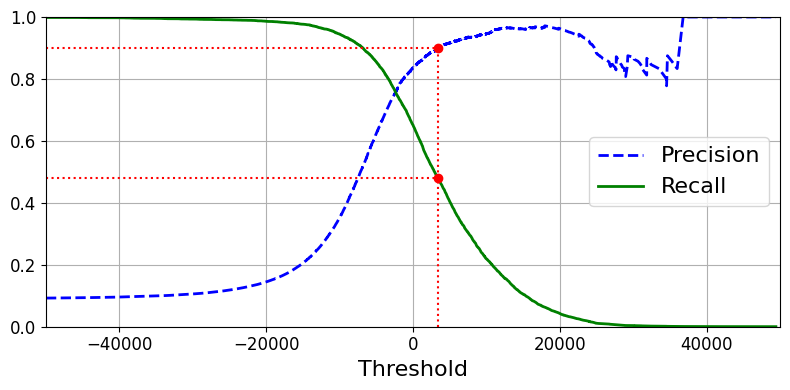

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16) 
    plt.grid(True)        
    plt.axis([-50000, 50000, 0, 1])



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

### **The Receiver Operating Characteristic (ROC) Curve**

It is very similar to the precision/recall curve but it plots *true positive rate* (another name for recall) and *false positive rate*. This FPR is the ratio of negative instances that are incorrectly classified as positives

It is equal to 1 - recall. Hence, ROC plots sensitives (recall) against 1 - specifiy

Saving figure roc_curve_plot


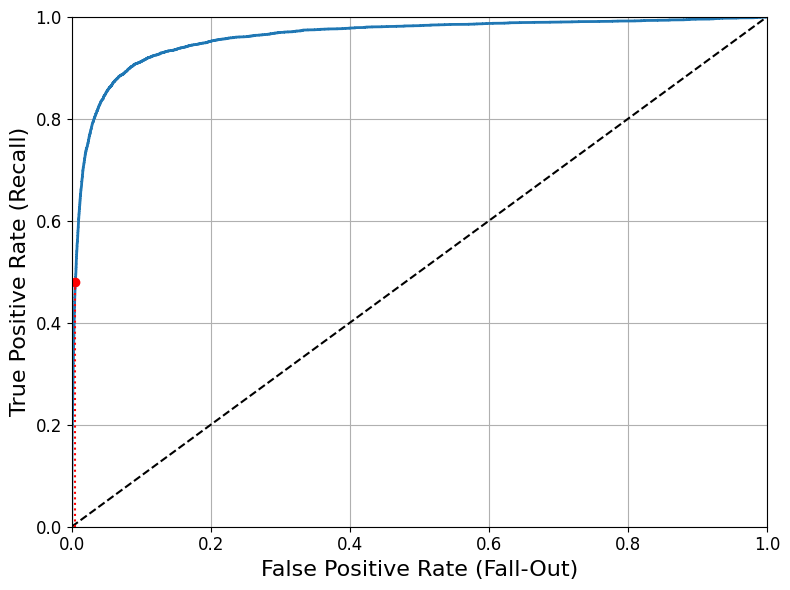

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

## **Multiclass Classification**

Also called, multinomial classifiers can distinguish between more than two classes. Some algorithms (SGDC, Random Forest, Bayes Classifiers) are capable of multiclass classification natively

### **One-Versus-Rest (OvR) Strategy**

One way is to create a system that classifies images into 10 classes. This way you train 10 binary classifiers, one for each digit and get the decision score from each classifier and select the class with highest score.

### **OvR Classifier using MNIST Dataset**

In [24]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == '5') # True for all 5s and false for all other digits
y_test_5 = (y_test == '5')

np.unique(y_train_5, return_counts=True)

from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [29]:
sgd_clf.predict([some_digit])

array([ True])

In [27]:
# Using cross-validation to evaluate the performance of a model and assess how well it will generalize to unseen data. It is a more robust method than a simple train-test split, especially when dealing with limited datasets
from sklearn.model_selection import cross_val_score

# K-fold cross-val means splitting training set into K folds and then making predicions and evaluating them on each fold using a model trained on the remaining folds
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [30]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_3 = (y_train == '3') # True for all 3s and false for all other digits
y_test_3 = (y_test == '3')

np.unique(y_train_3, return_counts=True)

from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_3)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [31]:
sgd_clf.predict([some_digit])

array([False])

In [32]:
# Using cross-validation to evaluate the performance of a model and assess how well it will generalize to unseen data. It is a more robust method than a simple train-test split, especially when dealing with limited datasets
from sklearn.model_selection import cross_val_score

# K-fold cross-val means splitting training set into K folds and then making predicions and evaluating them on each fold using a model trained on the remaining folds
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.9496 , 0.9624 , 0.96275])

### **One-Versus-One (OvO) Strategy**

Another strategy is to train a binary classifier for every pair of digits. If there are *N* classes, you need to train *N x (N-1)/2* classifiers